### Importing the images from the folders we have created

In [1]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\vivek\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
train_path = 'Data_Images/train_dir'
valid_path = 'Data_Images/val_dir'

num_train_samples = 0
for i in os.listdir(train_path):
    num_train_samples+=len(os.listdir(os.path.join(train_path, i)))

num_val_samples = 0
for i in os.listdir(valid_path):
    num_val_samples+=len(os.listdir(os.path.join(valid_path, i)))
    
print(num_train_samples, num_val_samples)

4604 406


In [3]:
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

### Set Up the Generators

In [4]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)


train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False)

# assign batch size to max size to convert Directory Iterator to numpy array
# X_train, y_train = train_batches.next()
# X_val, y_val = valid_batches.next()
# X_test, y_test = valid_batches.next()

Found 4604 images belonging to 7 classes.
Found 406 images belonging to 7 classes.
Found 406 images belonging to 7 classes.


In [5]:
# print (X_train.shape, y_train.shape)
# print (X_val.shape, y_val.shape)
# print (X_test.shape, y_test.shape)

### Modify MobileNet Model  (Transfer Learning)

In [6]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [8]:
type(mobile.layers)

list

In [9]:
# How many layers do mobile have 
len(mobile.layers)

91

In [10]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-1].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
# x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [11]:
predictions

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense')>

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [13]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Model Training

In [14]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [15]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])


In [16]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [17]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.5, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [18]:
filepath = "model_v2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

In [19]:
# history = model.fit(X_train, y_train, steps_per_epoch=train_steps, 
#                     class_weight=class_weights,
#                     validation_data=(X_val, y_val),
#                     validation_steps=val_steps,
#                     batch_size=train_batch_size,
#                     epochs=30, verbose=1,
#                    callbacks = callbacks_list)

In [20]:
history = model.fit(train_batches, steps_per_epoch=train_steps, 
                                class_weight=class_weights,
                                validation_data=valid_batches,
                                validation_steps=val_steps,
                                epochs=30, verbose=1,
                                callbacks=callbacks_list)

Epoch 1/30
461/461 [==============================] - ETA: 0s - loss: 1.8806 - categorical_accuracy: 0.2919 - top_2_accuracy: 0.4726 - top_3_accuracy: 0.6364
Epoch 1: val_top_3_accuracy improved from -inf to 0.70197, saving model to model_v2.h5
461/461 [==============================] - 147s 314ms/step - loss: 1.8806 - categorical_accuracy: 0.2919 - top_2_accuracy: 0.4726 - top_3_accuracy: 0.6364 - val_loss: 1.7836 - val_categorical_accuracy: 0.3202 - val_top_2_accuracy: 0.5788 - val_top_3_accuracy: 0.7020 - lr: 0.0100
Epoch 2/30
461/461 [==============================] - ETA: 0s - loss: 1.7677 - categorical_accuracy: 0.3102 - top_2_accuracy: 0.5106 - top_3_accuracy: 0.6555
Epoch 2: val_top_3_accuracy improved from 0.70197 to 0.75862, saving model to model_v2.h5
461/461 [==============================] - 146s 318ms/step - loss: 1.7677 - categorical_accuracy: 0.3102 - top_2_accuracy: 0.5106 - top_3_accuracy: 0.6555 - val_loss: 1.6402 - val_categorical_accuracy: 0.3571 - val_top_2_accura

461/461 [==============================] - 143s 310ms/step - loss: 1.5927 - categorical_accuracy: 0.3977 - top_2_accuracy: 0.6045 - top_3_accuracy: 0.7663 - val_loss: 1.5089 - val_categorical_accuracy: 0.3719 - val_top_2_accuracy: 0.6158 - val_top_3_accuracy: 0.7906 - lr: 3.1250e-04
Epoch 17/30
461/461 [==============================] - ETA: 0s - loss: 1.5968 - categorical_accuracy: 0.3960 - top_2_accuracy: 0.6049 - top_3_accuracy: 0.7676
Epoch 17: val_top_3_accuracy did not improve from 0.79064
461/461 [==============================] - 147s 319ms/step - loss: 1.5968 - categorical_accuracy: 0.3960 - top_2_accuracy: 0.6049 - top_3_accuracy: 0.7676 - val_loss: 1.5032 - val_categorical_accuracy: 0.3719 - val_top_2_accuracy: 0.6108 - val_top_3_accuracy: 0.7808 - lr: 3.1250e-04
Epoch 18/30
461/461 [==============================] - ETA: 0s - loss: 1.5938 - categorical_accuracy: 0.3994 - top_2_accuracy: 0.6056 - top_3_accuracy: 0.7626
Epoch 18: val_top_3_accuracy did not improve from 0.7906

### Evalaute the modell using the val set

In [35]:
# Here the best epoch will be used.

model.load_weights('model_v2.h5')


val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=num_val_samples)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\vivek\AppData\Local\Temp\ipykernel_27428\3141950700.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 1.5002986192703247
val_cat_acc: 0.3842364549636841
val_top_2_acc: 0.628078818321228
val_top_3_acc: 0.7980295419692993


In [36]:
# Here the best epoch will be used.

model.load_weights('model.h5')


val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=num_val_samples)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

C:\Users\vivek\AppData\Local\Temp\ipykernel_27428\3261252217.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 1.6162387132644653
val_cat_acc: 0.3177340030670166
val_top_2_acc: 0.5221675038337708
val_top_3_acc: 0.8103448152542114


### Plot the Training Curve

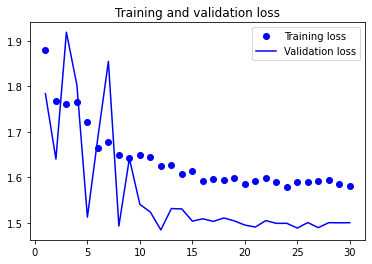

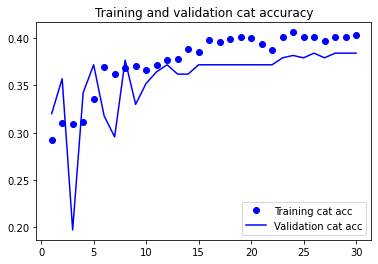

<Figure size 432x288 with 0 Axes>

In [39]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.show()

### Create a Confusion Matrix

In [40]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [41]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [42]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=num_val_samples, verbose=1)

C:\Users\vivek\AppData\Local\Temp\ipykernel_27428\1979356419.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=num_val_samples, verbose=1)


406/406 [==============================] - 7s 17ms/step


In [43]:
predictions.shape

(406, 7)

In [44]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [45]:
test_labels.shape

(406,)

In [46]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [47]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 0  0  0  0 40 12  0]
 [ 0  0  0  0 45 15  0]
 [ 0  0  0  0 28 47  0]
 [ 0  0  0  0  2 16  0]
 [ 0  0  0  0 40 38  0]
 [ 0  0  0  0  1 89  0]
 [ 0  0  0  0  0 33  0]]


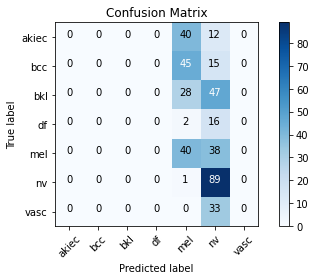

In [48]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')